# CW 03 Part 1

In [36]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
array_size = 300e-6  
num_pixels = 512  # Resolution

dx = array_size / num_pixels  # Pixel size

wvl = 633e-9
dz = 3e-6


# Create spatial coordinate grid
x = np.linspace(-array_size / 2, array_size / 2, num_pixels)
y = np.linspace(-array_size / 2, array_size / 2, num_pixels)
X, Y = np.meshgrid(x, y)

In [3]:
def angular_spectrum_propagation_range(U0, wvl, dx, dz, num_steps, absorptive_boundary= False):
    """
    Propagates an optical field using the Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 2D numpy array (input wavefield)
        wvl     : float (wavelength of light in meters)
        d_range : list or numpy array (range of propagation distances in meters)
        dx      : float (sampling interval in meters)

    Returns:
        U_list  : list of 2D numpy arrays (propagated wavefields for each distance in d_range)
    """
    
    # Get array size
    ny, nx = U0.shape
    k = 2 * np.pi / wvl  # Wave number

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)
    
    # Initialize list to store results
    U_list = []
    
    # Apply super Gaussian absorptive boundary

    if absorptive_boundary:
        sigma = nx/3.5  # Standard deviation for Gaussian
        X, Y = np.meshgrid(np.linspace(-nx/2, nx/2, nx), np.linspace(-ny/2, ny/2, ny))
        window = np.exp(-((X**2 + Y**2) / (2 * sigma**2))**4)
    else:
        window = np.ones_like(U0)
        
    H = np.exp(1j * k * dz * np.sqrt(0j+ 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    for _ in range(num_steps):
        
        # Apply transfer function
        U_spectrum = np.fft.fft2(U0) * H
        
        # Inverse FFT to obtain propagated field
        U0 = np.fft.ifft2(U_spectrum)
        U0 *= window
        U_list.append(U0)
        
    return U_list


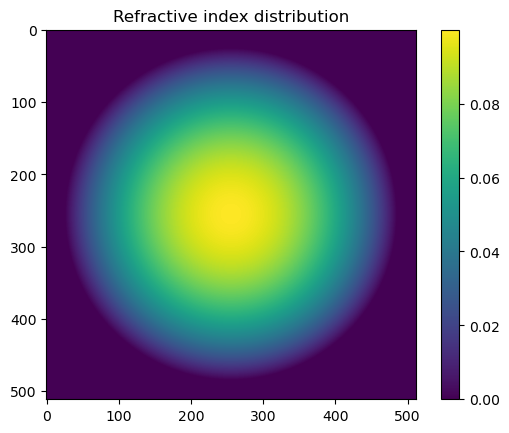

In [6]:
n_max = 1.1
alpha = 1e7
rho = np.sqrt(X**2+Y**2)
grin_dist = np.maximum(n_max*(1-alpha*rho**2/2)-1,0)
plt.imshow(grin_dist); plt.colorbar(); plt.title('Refractive index distribution'); plt.show()

In [7]:
def angular_spectrum_propagation_range_grin(U0, wvl, dx, dz, num_steps, num_steps_grin, grin_dist, absorptive_boundary= False):
    """
    Propagates an optical field using the Angular Spectrum Method over a range of distances.

    Parameters:
        U0      : 2D numpy array (input wavefield)
        wvl     : float (wavelength of light in meters)
        d_range : list or numpy array (range of propagation distances in meters)
        dx      : float (sampling interval in meters)

    Returns:
        U_list  : list of 2D numpy arrays (propagated wavefields for each distance in d_range)
    """
    
    # Define refractive index
    
    # Get array size
    ny, nx = U0.shape
    k = 2 * np.pi / wvl  # Wave number

    # Create spatial frequency coordinates
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy)
    
    # Initialize list to store results
    U_list = []
    
    # Apply super Gaussian absorptive boundary

    if absorptive_boundary:
        sigma = nx/3.5  # Standard deviation for Gaussian
        X, Y = np.meshgrid(np.linspace(-nx/2, nx/2, nx), np.linspace(-ny/2, ny/2, ny))
        window = np.exp(-((X**2 + Y**2) / (2 * sigma**2))**4)
    else:
        window = np.ones_like(U0)
        
    H = np.exp(1j * k * dz * np.sqrt(0j+ 1 - (wvl * FX) ** 2 - (wvl * FY) ** 2))

    for _ in range(num_steps_grin):
        
        # Apply transfer function
        U_spectrum = np.fft.fft2(U0*np.exp(1j*grin_dist*k*dz)) * H
        
        # Inverse FFT to obtain propagated field
        U0 = np.fft.ifft2(U_spectrum)
        U0 *= window
        U_list.append(U0)

    for _ in range(num_steps-num_steps_grin):
        
        # Apply transfer function
        U_spectrum = np.fft.fft2(U0) * H
        
        # Inverse FFT to obtain propagated field
        U0 = np.fft.ifft2(U_spectrum)
        U0 *= window
        U_list.append(U0)        
    return U_list


In [33]:
prop_distance = 0.6e-3
prop_steps = np.round(prop_distance / dz).astype(int)

prop_distance_grin = 0.18e-3
prop_steps_grin = np.round(prop_distance_grin / dz).astype(int)

U0 = np.ones_like(X)

grating_zs = angular_spectrum_propagation_range_grin(U0, wvl, dx, dz, prop_steps, prop_steps_grin,grin_dist, True)
array_3d = np.stack(grating_zs)


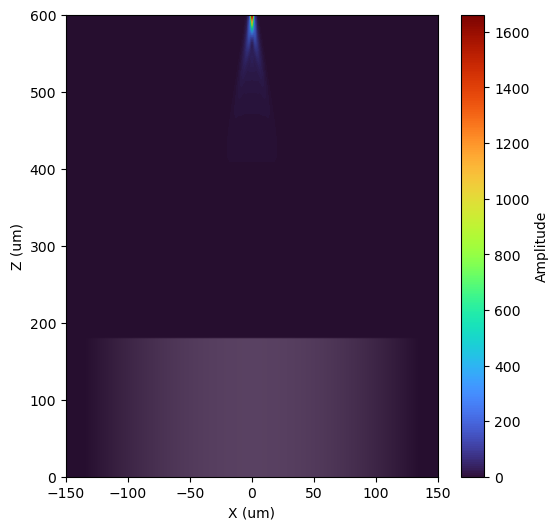

In [34]:
# Display the grating
plt.figure(figsize=(6, 6))

plt.imshow(np.abs(array_3d[:, 256, :])**2, cmap="turbo",aspect = 'auto',extent=[-array_size/2*1e6, array_size/2*1e6, prop_distance*1e6,0],alpha= 1.0)
plt.colorbar(label="Amplitude")
grin_dist_1d = grin_dist[256, :]
refractive_distribution = np.ones_like(np.abs(array_3d[:, 256, :]).squeeze())
refractive_distribution[0:prop_steps_grin] = 1+grin_dist_1d[None,:]
plt.imshow(np.flip(refractive_distribution,axis = 0), cmap="gray",aspect = 'auto',extent=[-array_size/2*1e6, array_size/2*1e6, 0, prop_distance*1e6],alpha= 0.2)

plt.xlabel("X (um)")
plt.ylabel("Z (um)")
plt.show()

In [ ]:
focal_distance = 1/(n_max*alpha*prop_distance_grin)*1e6+prop_distance_grin*1e6
print(focal_distance)


685.050505050505
